In [ ]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
from PIL import Image, ImageOps
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import exposure
import keras,os
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, TruePositives, FalsePositives, FalseNegatives
import keras.backend as K
from keras.utils import get_custom_objects
from keras.models import load_model

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/IDRID/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
test_df = pd.read_csv('/content/drive/MyDrive/IDRID/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')

train_df = train_df.loc[:, ['Image name', 'Retinopathy grade']]
test_df = test_df.loc[:, ['Image name', 'Retinopathy grade']]

print(train_df.shape)
print(test_df.shape)

print(train_df.head())


(413, 2)
(103, 2)
  Image name  Retinopathy grade
0  IDRiD_001                  1
1  IDRiD_002                  1
2  IDRiD_003                  1
3  IDRiD_004                  1
4  IDRiD_005                  1


In [ ]:
train_df['Retinopathy grade'].value_counts()

1    279
0    134
Name: Retinopathy grade, dtype: int64

<Axes: >

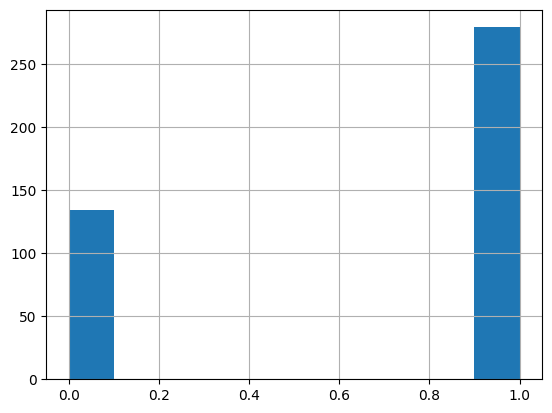

In [ ]:
train_df['Retinopathy grade'].hist()

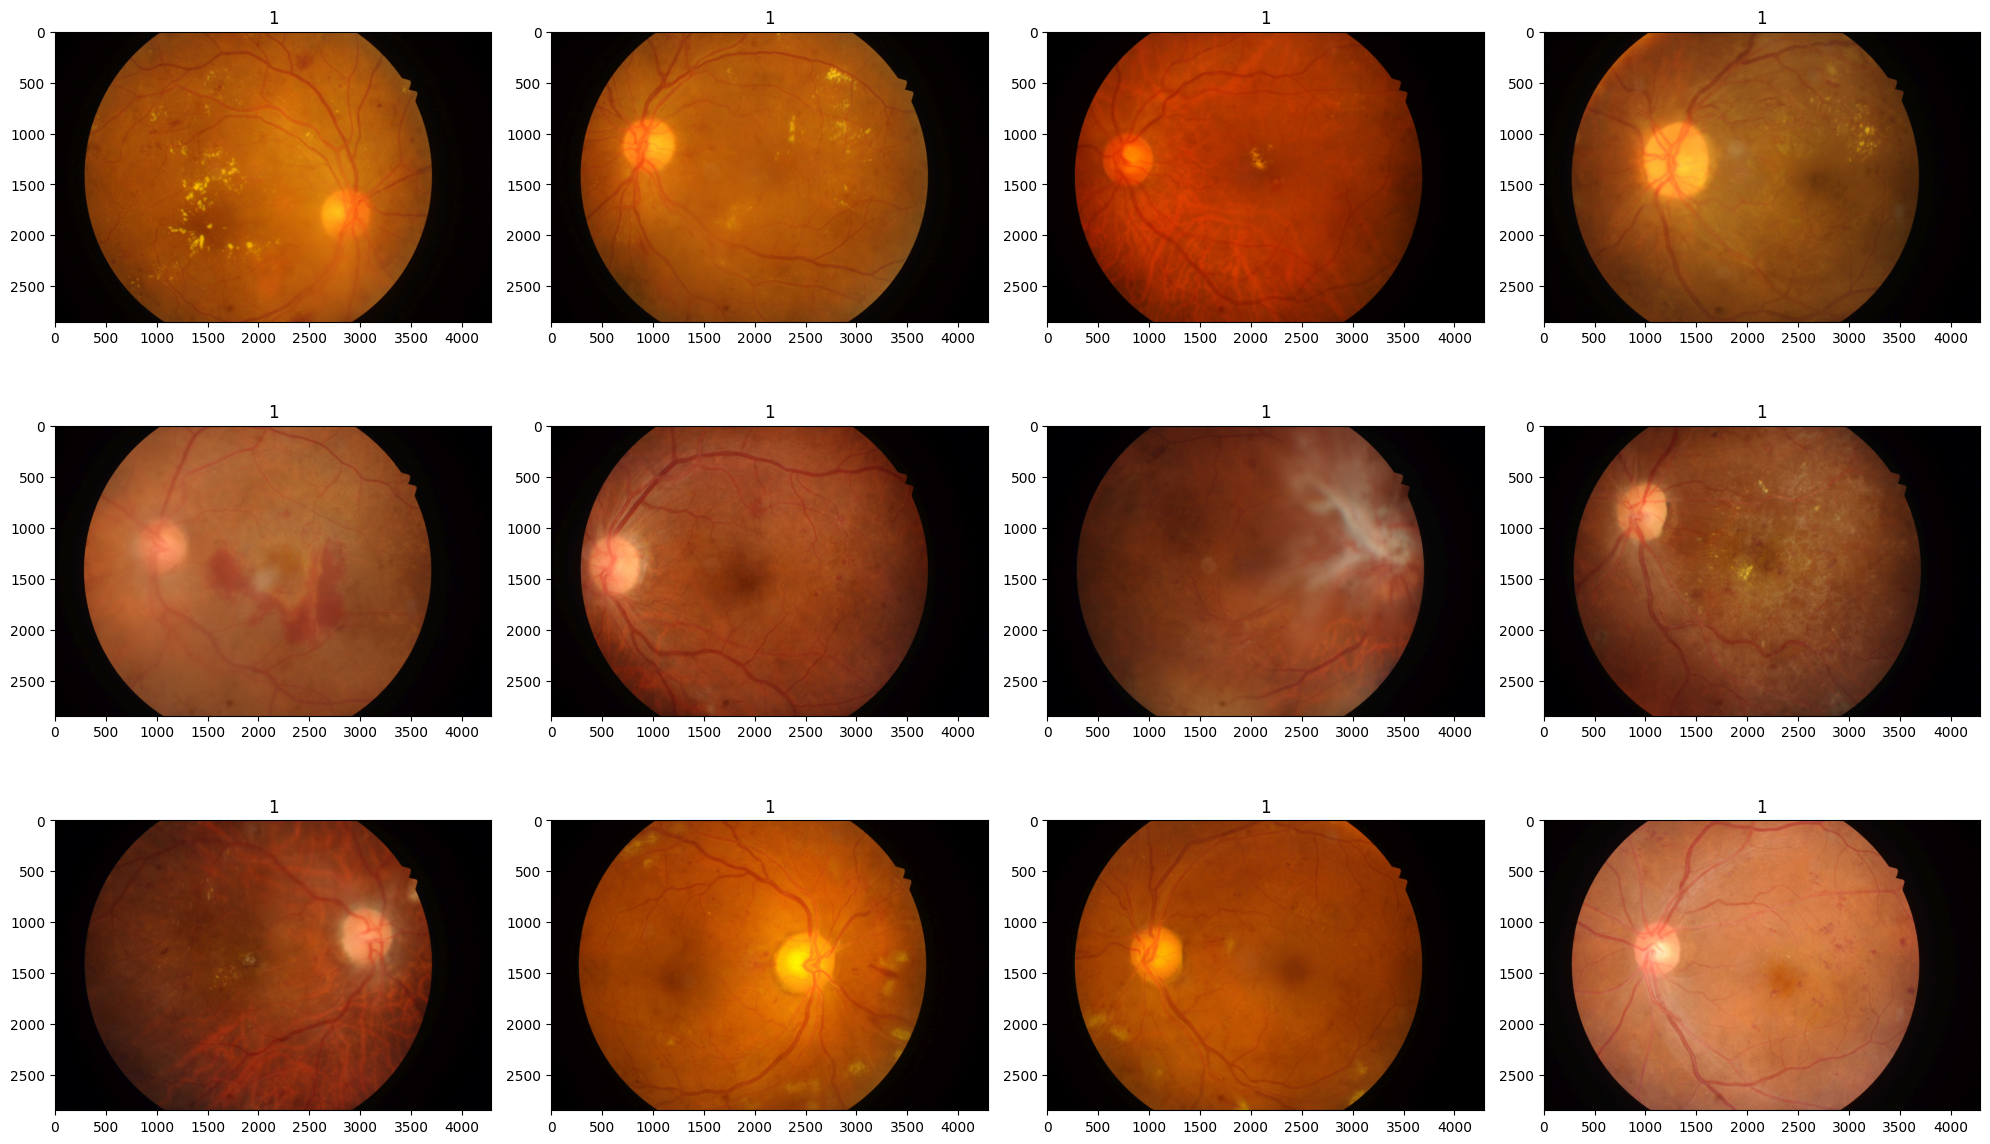

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'Image name']
        image_id = df.loc[i,'Retinopathy grade']
        img = cv2.imread(f'/content/drive/MyDrive/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{image_path}.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [ ]:


def convert_to_grayscale(image_path):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    return im

In [ ]:

def apply_clahe(image):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Apply CLAHE to the image
    cl_img = clahe.apply(image)
    
    return cl_img



In [ ]:

def resize_image(image, desired_size=256):
    image = cv2.resize(image, (desired_size, desired_size))
    
    return image

In [ ]:


N = train_df.shape[0]
x_train = np.empty((N, 256, 256, 1), dtype=np.float32)

for i, image_id in enumerate(tqdm(train_df['Image name'])):
    image = convert_to_grayscale(f'/content/drive/MyDrive/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{image_id}.jpg')
    image = apply_clahe(image)
    image = resize_image(image)
    x_train[i, :, :, 0] = image
    
N = test_df.shape[0]
x_test = np.empty((N, 256, 256, 1), dtype=np.float32)

for i, image_id in enumerate(tqdm(test_df['Image name'])):
    image = convert_to_grayscale(f'/content/drive/MyDrive/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{image_id}.jpg')
    image = apply_clahe(image)
    image = resize_image(image)
    x_test[i, :, :, 0] = image





100%|██████████| 103/103 [00:21<00:00,  4.71it/s]


In [ ]:

x_train = x_train / 255.
x_test = x_test / 255.



In [ ]:
y_train = train_df['Retinopathy grade']
y_test = test_df['Retinopathy grade']
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(413, 256, 256, 1)
(413,)
(103, 256, 256, 1)
(103,)


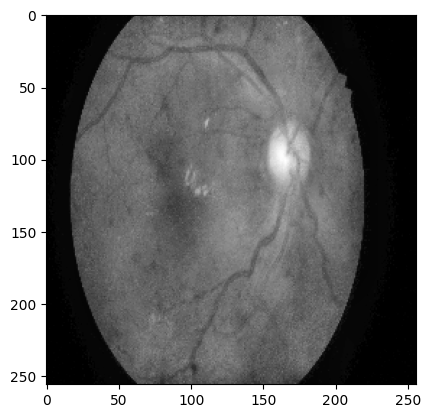

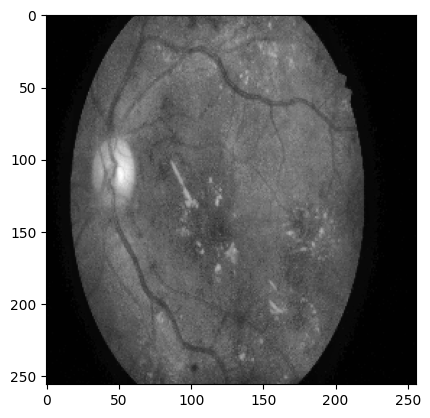

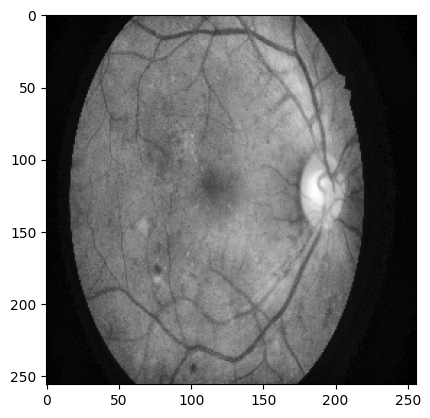

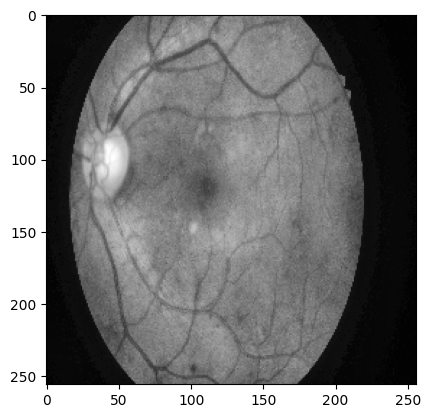

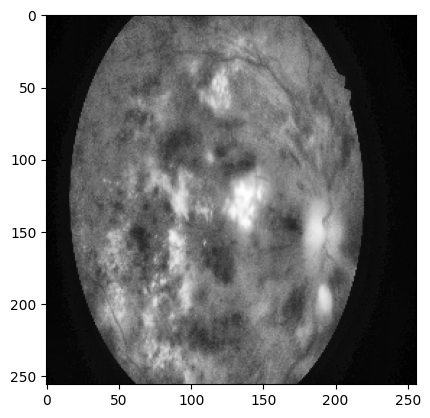

In [ ]:

plt.imshow(x_train[17], cmap='gray')
plt.show()

plt.imshow(x_train[18], cmap='gray')
plt.show()

plt.imshow(x_train[19], cmap='gray')
plt.show()

plt.imshow(x_train[20], cmap='gray')
plt.show()

plt.imshow(x_train[21], cmap='gray')
plt.show()

In [ ]:

train_datagen = ImageDataGenerator(
                                   rotation_range=10,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator




In [ ]:
batch_size = 32

# Compute mean pixel value over the training dataset
# mean = np.mean(x_train, axis=(0, 1, 2))

# Subtract mean pixel value from each pixel
# x_train = x_train - mean
# x_test = x_test - mean


# Normalizing the data
# x_train = x_train / 255.
# x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


# train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

# test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

# Loading training data
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=516).batch(batch_size)
train_ds=train_ds.repeat()

# Loading testing data
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(batch_size)




In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(413, 256, 256, 1)
(413, 2)
(103, 256, 256, 1)
(103, 2)


In [ ]:
image_batch, labels_batch = next(iter(train_generator))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

the min and max values of the normalized images are not exactly 0 and 1 but are close to them

In [ ]:


# Define model architecture
model = Sequential()

# Add layers

model.add(Conv2D(input_shape=(256,256,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(32 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(2 , activation="sigmoid"))


In [ ]:

# def build_unet(input_shape):
#     inputs = keras.layers.Input(shape=input_shape)

#     # Encoder
#     conv1 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
#     conv1 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(conv1)
#     pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(pool1)
#     conv2 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(conv2)
#     pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(pool2)
#     conv3 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(conv3)
#     pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same")(pool3)
#     conv4 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same")(conv4)
#     drop4 = keras.layers.Dropout(rate=0.5)(conv4)
#     pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

#     # Decoder
#     up5 = keras.layers.UpSampling2D(size=(2, 2))(pool4)
#     up5 = keras.layers.Conv2D(filters=256, kernel_size=(2, 2), activation="relu", padding="same")(up5)
#     merge5 = keras.layers.concatenate([drop4, up5], axis=3)
#     conv5 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(merge5)
#     conv5 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(conv5)

#     up6 = keras.layers.UpSampling2D(size=(2, 2))(conv5)
#     up6 = keras.layers.Conv2D(filters=128, kernel_size=(2, 2), activation="relu", padding="same")(up6)
#     merge6 = keras.layers.concatenate([conv3, up6], axis=3)
#     conv6 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(merge6)
#     conv6 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(conv6)

#     up7 = keras.layers.UpSampling2D(size=(2, 2))(conv6)
#     up7 = keras.layers.Conv2D(filters=64, kernel_size=(2, 2), activation="relu", padding="same")(up7)
#     merge7 = keras.layers.concatenate([conv2, up7], axis=3)
#     conv7 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(merge7)
#     conv7 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(conv7)

#     up8 = keras.layers.UpSampling2D(size=(2, 2))(conv7)
#     up8 = keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation="relu", padding="same")(up8)
#     merge8 = keras.layers.concatenate([conv1, up8], axis=3)
#     conv8 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(merge8)
#     conv8 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(conv8)

#     outputs = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation="softmax")(conv8)

#     model = keras.Model(inputs=inputs, outputs=outputs)

#     return mode

In [ ]:
# from keras.applications.vgg16 import VGG16

# Vgg16 = VGG16(include_top=False, input_shape= (256,256,3)) 

# Vgg16.trainable=False

In [ ]:
# model = Sequential()
# model.add(Vgg16)
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(64 , activation="relu"))
# model.add(Dropout(0.25))
# model.add(Dense(32 , activation="relu"))
# model.add(Dropout(0.25))
# model.add(Dense(2 , activation="sigmoid"))

In [ ]:
def F1Score(num_classes):
    def f1score(y_true, y_pred):
        y_true = K.argmax(y_true, axis=-1)
        y_pred = K.argmax(y_pred, axis=-1)
        y_true = K.one_hot(y_true, num_classes)
        y_pred = K.one_hot(y_pred, num_classes)
        tp = K.sum(y_true * y_pred, axis=0)
        fp = K.sum((1 - y_true) * y_pred, axis=0)
        fn = K.sum(y_true * (1 - y_pred), axis=0)
        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())
        f1score = 2 * precision * recall / (precision + recall + K.epsilon())
        weighted_f1score = K.sum(f1score * K.sum(y_true, axis=0)) / K.sum(y_true)
        return weighted_f1score
    return f1score

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
get_custom_objects().update({'sensitivity': sensitivity})
get_custom_objects().update({'specificity': specificity})
get_custom_objects().update({'f1score': F1Score(num_classes=2)})

In [ ]:


# Adam optimizer and loss
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', sensitivity, specificity, F1Score(num_classes=2)])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                  

In [ ]:
# Early stopping and modelcheckpoint

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto')


In [ ]:

history = model.fit_generator(generator=train_ds , epochs=30,steps_per_epoch=50, validation_data=test_ds,validation_steps=10, verbose=1 , callbacks = [checkpoint,early])

In [ ]:
model.evaluate(test_ds)

In [ ]:
# model.save('vgg16_1.h5')

In [ ]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(ytrue, ypred)
# print(cm)

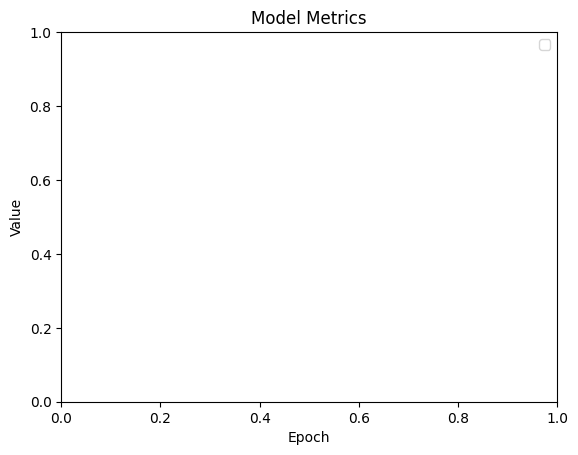

In [ ]:


# Visualizing training/validation accuracy and loss using matplotlib

plt.title("Model Metrics")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["accuracy","Validation Accuracy","Loss", "sensitivity", "specificity", "F1 Score"])
plt.show()


In [ ]:

# Load the saved models
model_dr_path = '/content/drive/MyDrive/vgg16_1.h5'  
model_pdr_path = '/content/drive/MyDrive/vgg16_2.h5'

model_dr = load_model(model_dr_path)
model_npdr_pdr = load_model(model_pdr_path)


In [ ]:
# Pass the image through the first model

prediction_dr = model_dr.predict(test_ds)
if prediction_dr.max() > 0.5:
    print("The image has diabetic retinopathy (DR).")
  # Pass the image through the second model
    prediction_npdr_pdr = model_npdr_pdr.predict(test_ds)
    if prediction_npdr_pdr.max() > 0.5:
        print("The severity is proliferative diabetic retinopathy (PDR).")
    else:
        print("The severity is non-proliferative diabetic retinopathy (NPDR).")
else:
    print("The image does not have diabetic retinopathy (DR).")

4/4 [==============================] - 1s 159ms/step
The image has diabetic retinopathy (DR).
4/4 [==============================] - 1s 141ms/step
The severity is proliferative diabetic retinopathy (PDR).
